# This code is intended to be used for offline analysis of the seismic data retreived from the WebDAQ during site surveying.

## You may need to update the widget package to make this work.

### pip install ipywidgets --upgrade
### conda install conda-forge::ipywidgets

# ---------------------
# Do not run all 
# ---------------------

## Run one cell at a time or plots may not populate

In [2]:
print("thinking...")
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider
print("thinking...")
from ipywidgets import FloatSlider
from ipywidgets import Layout 
from scipy import signal
from matplotlib import gridspec
from scipy.fft import fftshift
import warnings
import os
print("ready (☆•ヮ•)八(•ヮ•)")

thinking...
thinking...
ready (☆•ヮ•)八(•ヮ•)


## This creates a GUI to select the data file you wish to use and selects the necessary data
### A program window will appear in your taskbar, this will bring up the GUI
# The GUI will start in the directory of the code. You will have to manually navigate to the Downloads folder to select the proper file you wish
### When you have selected your file, close the program window

In [5]:
file_path_global = None ## Variable for data path 

def upload_file():
    global file_path_global ## makes variable global 
    

    file_path_global = filedialog.askopenfilename(title="Select a file", filetypes=[("CSV Files", "*.csv")])
    
    print(f"File selected: {file_path_global}")
    print("\nClose the program window")
    
root = tk.Tk() ## Create the program window
root.title("Multi File Uploader")

upload_button = tk.Button(root, text="Upload File", command=upload_file) ## Create buttons for uploading files
upload_button.pack(pady=10)

root.mainloop() ## Runs the application


################################################################################################################################
#------------------------------------------------- Selects info from metadata -------------------------------------------------#
################################################################################################################################


metadata_rows = []
metadata = {}

with open(file_path_global, 'r') as f:
    for _ in range(5):
        metadata_rows.append(f.readline().strip()) 

for row in metadata_rows:
    if ':' in row: 
        key, value = row.split(':', 1)
        metadata[key.strip()] = value.strip()
     
    
########################################### This is the sample rate from the metadata ##########################################

sr = float(metadata["Sample Rate"])
print("\nSample Rate: " + metadata["Sample Rate"]) #-------------- Prints out the sample rate as a sanity check ---------------#

################################################################################################################################
                 
    
seis = pd.read_csv(file_path_global, skiprows = 5, delimiter=',') 

seis.columns = ["Sample", "Time (s)", "Noise (V)", "Channel E (V)", "Channel N (V)", "Channel Z (V)", "blank"]

sam = seis['Sample']
tim = seis['Time (s)']
noi = seis['Noise (V)'] * (0.0125e-1)/21
z = seis['Channel Z (V)'] * (0.0125e-1)/21 #---------------- This is the conversion factor for Volts to Tesla -----------------#
n = seis['Channel N (V)'] * (0.0125e-1)/21 
e = seis['Channel E (V)'] * (0.0125e-1)/21

################################################################################################################################

script_dir = os.getcwd()
control_data_path = os.path.join(script_dir, 'ligo_seis_data.txt')

if os.path.exists(control_data_path):
    huddle = pd.read_csv(control_data_path, delimiter="\s+")

    huddle.columns = ["frequency", "x", "y", "z"]

    hf = huddle["frequency"]
    hx = huddle["x"] * 0.0076 * 10 ** -6
    hy = huddle["y"] * 0.0076 * 10 ** -6 
    hz = huddle["z"] * 0.0076 * 10 ** -6
    
else:
    print("LIGO data not found\n")

print("\nFinished (ﾉ◕ヮ◕)ﾉ*:･ﾟ✧")

File selected: C:/Users/cacam/Documents/data_files/10-01-compare/seismo_test_cal_2024-10-01T22-07-09-752.csv
Close the program window

Sample Rate: 1651.6129032258063

Finished (ﾉ◕ヮ◕)ﾉ*:･ﾟ✧


## The following cell displays the time series of the recorded data

In [ ]:
############################################ You can define the y limits #######################################################

ylimmax = None
ylimmin = None

####################### You can change the linestyle/order in which they are ploted for ease of viewing ########################
plt.figure(figsize = (19, 11))
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(16)

plt.plot(tim,z, linewidth = 1.5, color = 'black', label = 'Z') 
plt.plot(tim,n, linewidth = 1.5, color = 'red', label = 'N')
plt.plot(tim,e, linewidth = 1.5, color = 'mediumblue', label = 'E')
#plt.plot(tim,noi, linewidth = 1.5, color = 'yellow', label = 'Noise')

plt.legend(loc = "upper right", fontsize = 18)
plt.title("Seismic Data Time Series", fontweight = 'bold', fontsize = 25)
plt.xlabel("Time (s)", fontweight = "bold", fontsize = 20)
plt.ylabel("Amplitude (m/s)", fontweight = "bold", fontsize = 20)

plt.xlim(0, tim[len(tim)-1])
plt.ylim(ylimmin,ylimmax)

plt.yticks(fontsize = 20, fontweight = "bold")
plt.xticks(fontsize = 20, fontweight = "bold")
plt.grid(True)

#.savefig('**place_img_name_here.format**', bbox_inches='tight')

## If you want to look at a specific time along the time series, you can use the slider plot below. 

### These variables are used to adjust the how many seconds are displayed and the step length

In [14]:
win = 15  ## sec displayed
stepy = 4  ## sec moved
buffer = 1e-6

## Beware, there may be a slight time delay when slidering

## If the slider is not workering move to the next cell

In [18]:
Min = min(z.min(), n.min(), e.min())  #------------------------- This is to find the window height ----------------------------#
Max = max(z.max(), n.max(), e.max())


#---------------------------------------- This function is what makes the slider run ------------------------------------------#
#------------------------------------------- Parameters can be changed as needed ----------------------------------------------#


def plot_with_slider(xlim):
    
    plt.figure(figsize=(19, 8))   ## dpi breaks slider
    ax = plt.gca()
    ax.yaxis.get_offset_text().set_fontsize(16)
    
    plt.plot(tim, z, linewidth = 1.5, label = 'Z', color = 'black')
    plt.plot(tim, n, linewidth = 1.5, label = 'N', color = 'red')
    plt.plot(tim, e, linewidth = 1.5, label = 'E', color = 'blue')
    
    plt.xlim(xlim, xlim + win) #---------------------- This is how long the window is (CAN be changed) ------------------------#
    plt.ylim(Min - buffer, Max + buffer) #-------- This adds a buffer to the window height (CAN be changed) -------------------#
    
    plt.legend(loc = 'upper right', fontsize = 15)
    plt.title("Slider Time Series", fontweight = 'bold', fontsize = 25)
    plt.xlabel("Time [s]", fontweight = "bold", fontsize = 20)
    plt.ylabel("Amplitude [m/s]", fontweight = "bold", fontsize = 20)
    plt.yticks(fontsize = 20, fontweight = "bold")
    plt.xticks(fontsize = 20, fontweight = "bold")
    plt.grid(True)
    plt.show()

#--------------------------------------- This is where the slider plot gets plotted -------------------------------------------#
#--- min,max = start,end ; step is the increment it slides on ; value is where it starts ; layout is how long the slider is ---#
#---------------------------------------------- step and layout CAN be changed ------------------------------------------------#

interact(plot_with_slider, xlim = FloatSlider(min = 0, max = (tim[len(tim)-1]), step = stepy, value = 0, 
                                              layout=Layout(width='980px')))


interactive(children=(FloatSlider(value=0.0, description='xlim', layout=Layout(width='980px'), max=58.99627, s…

<function __main__.plot_with_slider(xlim)>

## If you want to look at spectra of specific parts of the time series, you can set the time limits here

## If not, skip this cell

In [ ]:
################################### Enter how long of a time segment you'd like to look at #####################################

start = 0  ## In terms of seconds
end = 11

############################################### This indexes the data frames ###################################################

gamma = int(start * sr)
delta = int(end * sr)

z1 = z[gamma:delta]
n1 = n[gamma:delta]
e1 = e[gamma:delta]

# These are variables to calculate the ASD and plot limits

In [6]:
#-------------------------------------------------------- Plot limits ---------------------------------------------------------#
x_max = 100 ## in terms of frequency
x_min = 0.1

#----------------------------------------------------- Velocity Y limits ------------------------------------------------------#
y_max = 10e-6 ## in terms of ms⁻¹/√Hz
y_min = 50e-12  

#--------------------------------------------------- Displacement Y Limits ----------------------------------------------------#
my_max = 10e-7 ## in terms of m/√Hz
my_min = 10e-12

#-------------------------------------------------------- fft length ----------------------------------------------------------#
fft_length = 128 ## in terms of seconds

#---------------------------------------------------- Precent FFT Overlap -----------------------------------------------------#
overlap = 50 ## 50% fft overlap

# This is where the ASD is calculated and plotted

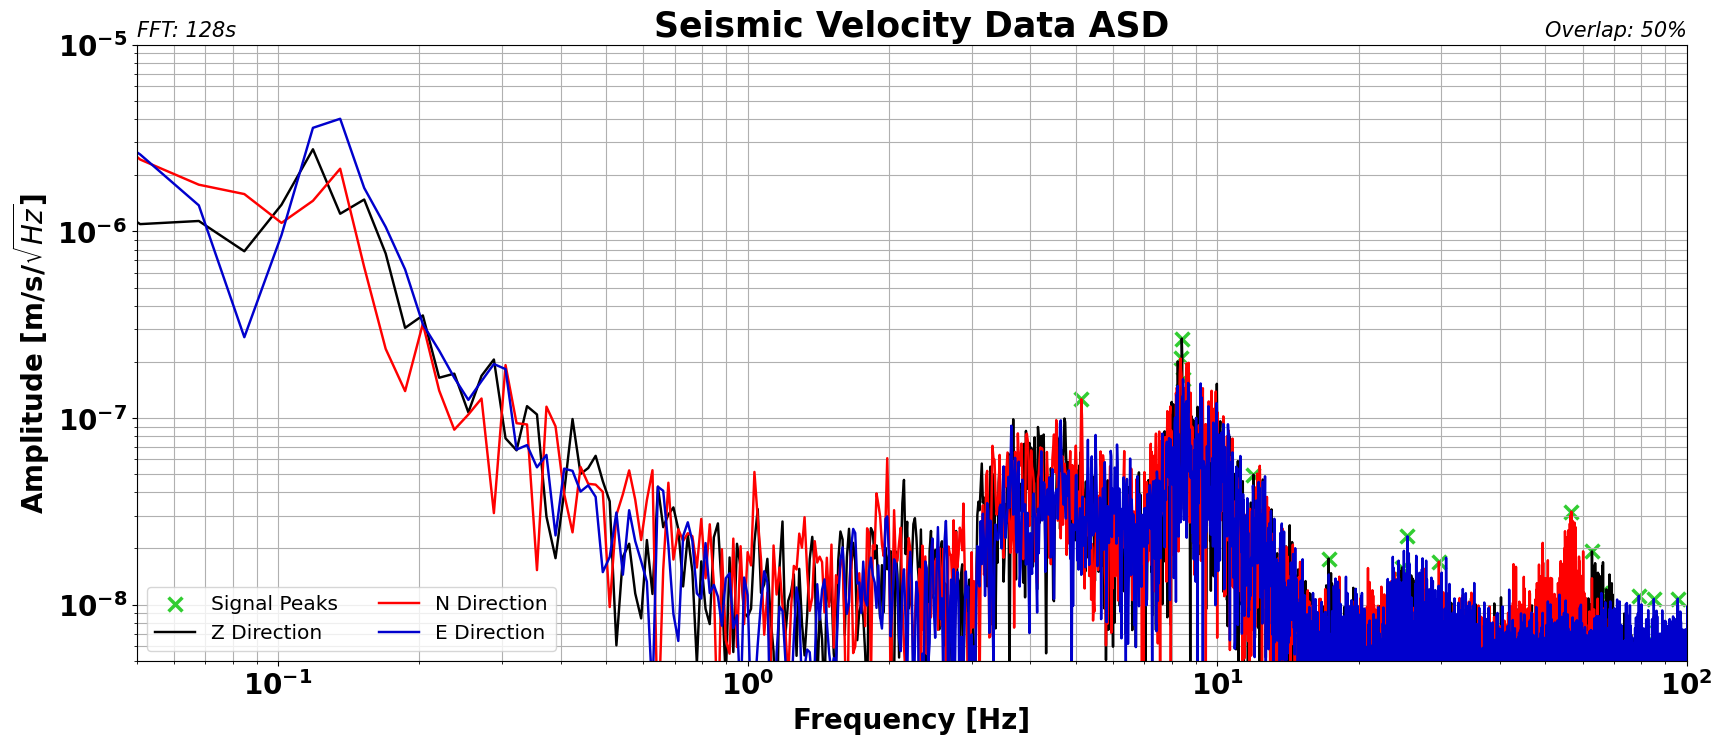

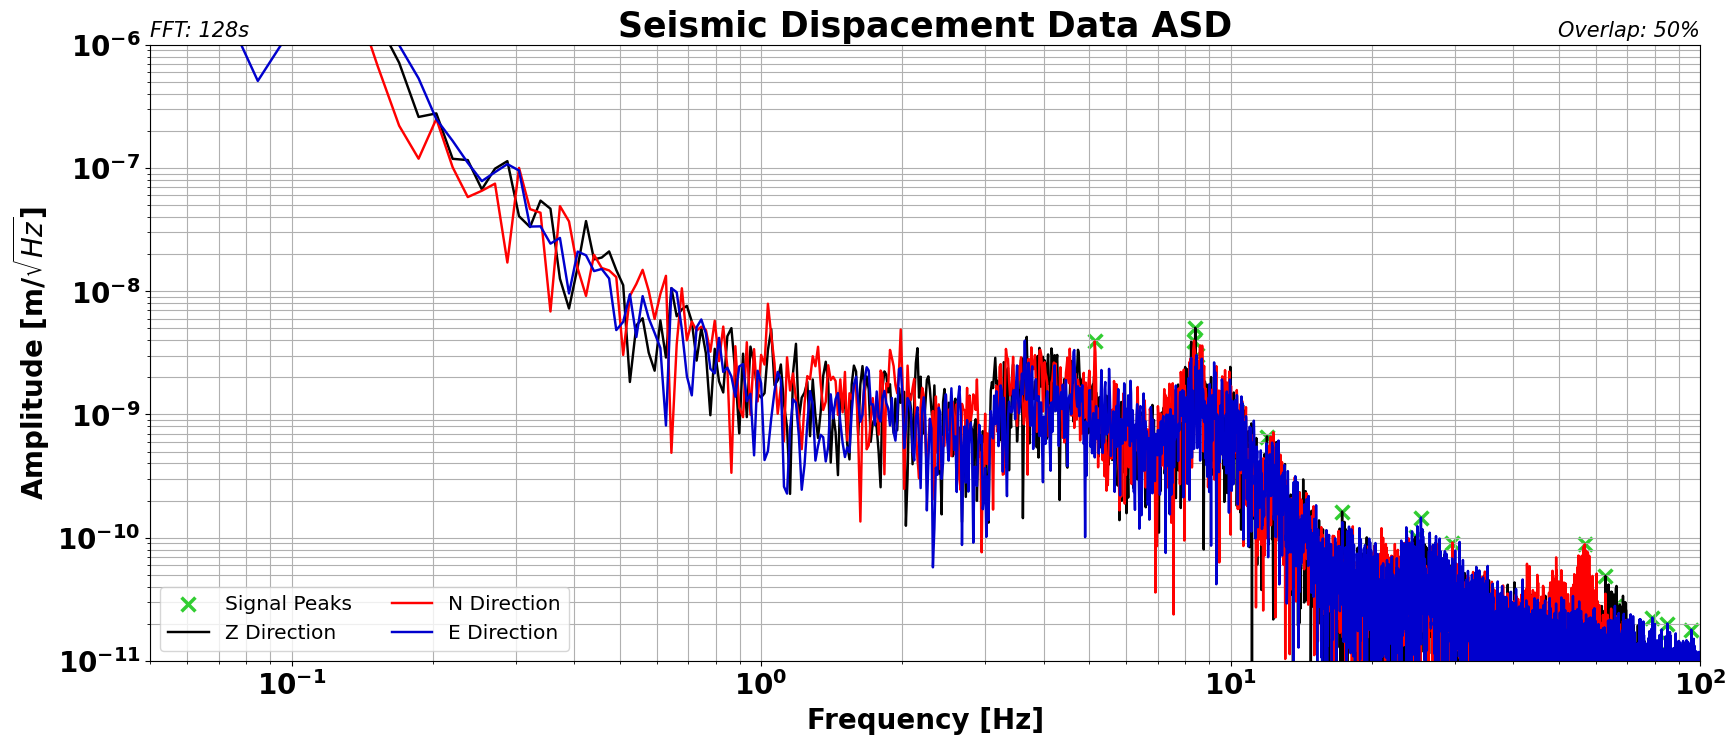

In [7]:
################################################################################################################################
#----------------------------------------- The PSD is calculated via welch from scipy -----------------------------------------#
################################################################################################################################
warnings.simplefilter('ignore')


#----------# If you don't want to look at the whole time series, you can add '1' to the variables, i.e z1, y1, x1 #------------#

                           #  z1
f_z, Pxx_den_z = signal.welch(z, sr, window= 'hamming', nperseg= (sr *fft_length), noverlap= round(sr *(overlap *0.01)) )
f_n, Pxx_den_n = signal.welch(n, sr, window= 'hamming', nperseg= (sr *fft_length), noverlap= round(sr *(overlap *0.01)) )
f_e, Pxx_den_e = signal.welch(e, sr, window= 'hamming', nperseg= (sr *fft_length), noverlap= round(sr *(overlap *0.01)) )


#------------------ nfft is how long the fft bin lengths, noverlap is bin overlap, window is the window used ------------------#
#---------------------- We used 100 sec bins, 0.5 sec overlap, and hamming window, these can be changed -----------------------#
#------------------------------------------------ # DO NOT CHANGE/REMOVE 'fs' # -----------------------------------------------#


az = np.sqrt(Pxx_den_z)
an = np.sqrt(Pxx_den_n) #---------------------------------- This turns the PSD into an ASD ------------------------------------#
ae = np.sqrt(Pxx_den_e)

mz = az / (2*np.pi *f_z)
mn = an / (2*np.pi *f_n) #----------------------------------------- Converts m/s to m -----------------------------------------#
me = ae / (2*np.pi *f_e)


log_z = np.log(az)
log_n = np.log(an) #---------------- The log of each ASD must be found in order to find the peaks/frequences ------------------#
log_e = np.log(ae)


peak_z, _ = signal.find_peaks(log_z,
                              prominence = 4.5) #------------------- This is where the frequencies are found ------------------#
peak_n, _ = signal.find_peaks(log_n, 
                              prominence = 4.5) #-------------------- If some are missed or there are extra -------------------#
peak_e, _ = signal.find_peaks(log_e, 
                              prominence = 4.5) #--------------- you will need to change the prominence variable --------------#


################################################################################################################################
#----------------------------------------------------- Plots Velocity ---------------------------------------------------------#
################################################################################################################################



plt.figure(1, figsize = (20, 8))#, dpi = 2500)

plt.yscale('log')
plt.xscale('log')

#------------------------------------------------------ Plots peaks -----------------------------------------------------------#


plt.scatter(f_z[peak_z], az[peak_z], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5, label = 'Signal Peaks')
plt.scatter(f_n[peak_n], an[peak_n], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5)
plt.scatter(f_e[peak_e], ae[peak_e], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5)

#---------------------------------------------------- PLots Spectra -----------------------------------------------------------#

plt.plot(f_z, az, color = 'black', linewidth = 1.75, label = 'Z Direction')
plt.plot(f_n, an, color = 'red', linewidth = 1.75, label = 'N Direction')
plt.plot(f_e, ae, color = 'mediumblue', linewidth = 1.75, label = 'E Direction')

plt.legend(loc = "lower left", fontsize = 14.5, ncol = 2)

plt.title('FFT: ' + str(fft_length) + "s", fontsize = 15, loc = "left",style ='italic')
plt.title("Overlap: " + str(overlap) + "%", fontsize = 15, loc = "right",style ='italic')

plt.title("Seismic Velocity Data ASD", fontweight = 'bold', fontsize = 25)
plt.xlabel("Frequency [Hz]", fontweight = "bold", fontsize = 20)
plt.ylabel("Amplitude [ms⁻¹/√Hz]", fontweight = "bold", fontsize = 20)

plt.yticks(fontsize = 20, fontweight = "bold")
plt.xticks(fontsize = 20, fontweight = "bold")

plt.ylim(y_min,y_max)
plt.xlim(x_min,x_max)

plt.grid(True, which="both", ls="-")

#plt.savefig('place_img_name_here.format', bbox_inches='tight')


################################################################################################################################
#---------------------------------------------------- Plots Displacement ------------------------------------------------------#
################################################################################################################################


plt.figure(2, figsize = (20, 8))#, dpi = 2500)
plt.yscale('log')
plt.xscale('log')

#------------------------------------------------------ Plots peaks -----------------------------------------------------------#

plt.scatter(f_z[peak_z], mz[peak_z], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5, label = 'Signal Peaks')
plt.scatter(f_n[peak_n], mn[peak_n], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5)
plt.scatter(f_e[peak_e], me[peak_e], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5)

#---------------------------------------------------- PLots Spectra -----------------------------------------------------------#

plt.plot(f_z, mz, color = 'black', linewidth = 1.75, label = 'Z Direction')
plt.plot(f_n, mn, color = 'red', linewidth = 1.75, label = 'N Direction')
plt.plot(f_e, me, color = 'mediumblue', linewidth = 1.75, label = 'E Direction')

plt.legend(loc = "lower left", fontsize = 14.5, ncol = 2)

plt.title('FFT: ' + str(fft_length) + "s", fontsize = 15, loc = "left",style ='italic')
plt.title("Overlap: " + str(overlap) + "%", fontsize = 15, loc = "right",style ='italic')

plt.title("Seismic Dispacement Data ASD", fontweight = 'bold', fontsize = 25)
plt.xlabel("Frequency [Hz]", fontweight = "bold", fontsize = 20)
plt.ylabel("Amplitude [m/√Hz]", fontweight = "bold", fontsize = 20)

plt.yticks(fontsize = 20, fontweight = "bold")
plt.xticks(fontsize = 20, fontweight = "bold")

plt.ylim(my_min,my_max)
plt.xlim(x_min,x_max)

plt.grid(True, which="both", ls="-")

#plt.savefig('place_img_name_here.format', bbox_inches='tight')

## The following cell will plot each of direction signal in their own respective plots
### If you don't want/need to look at them individually, you don't have to run it

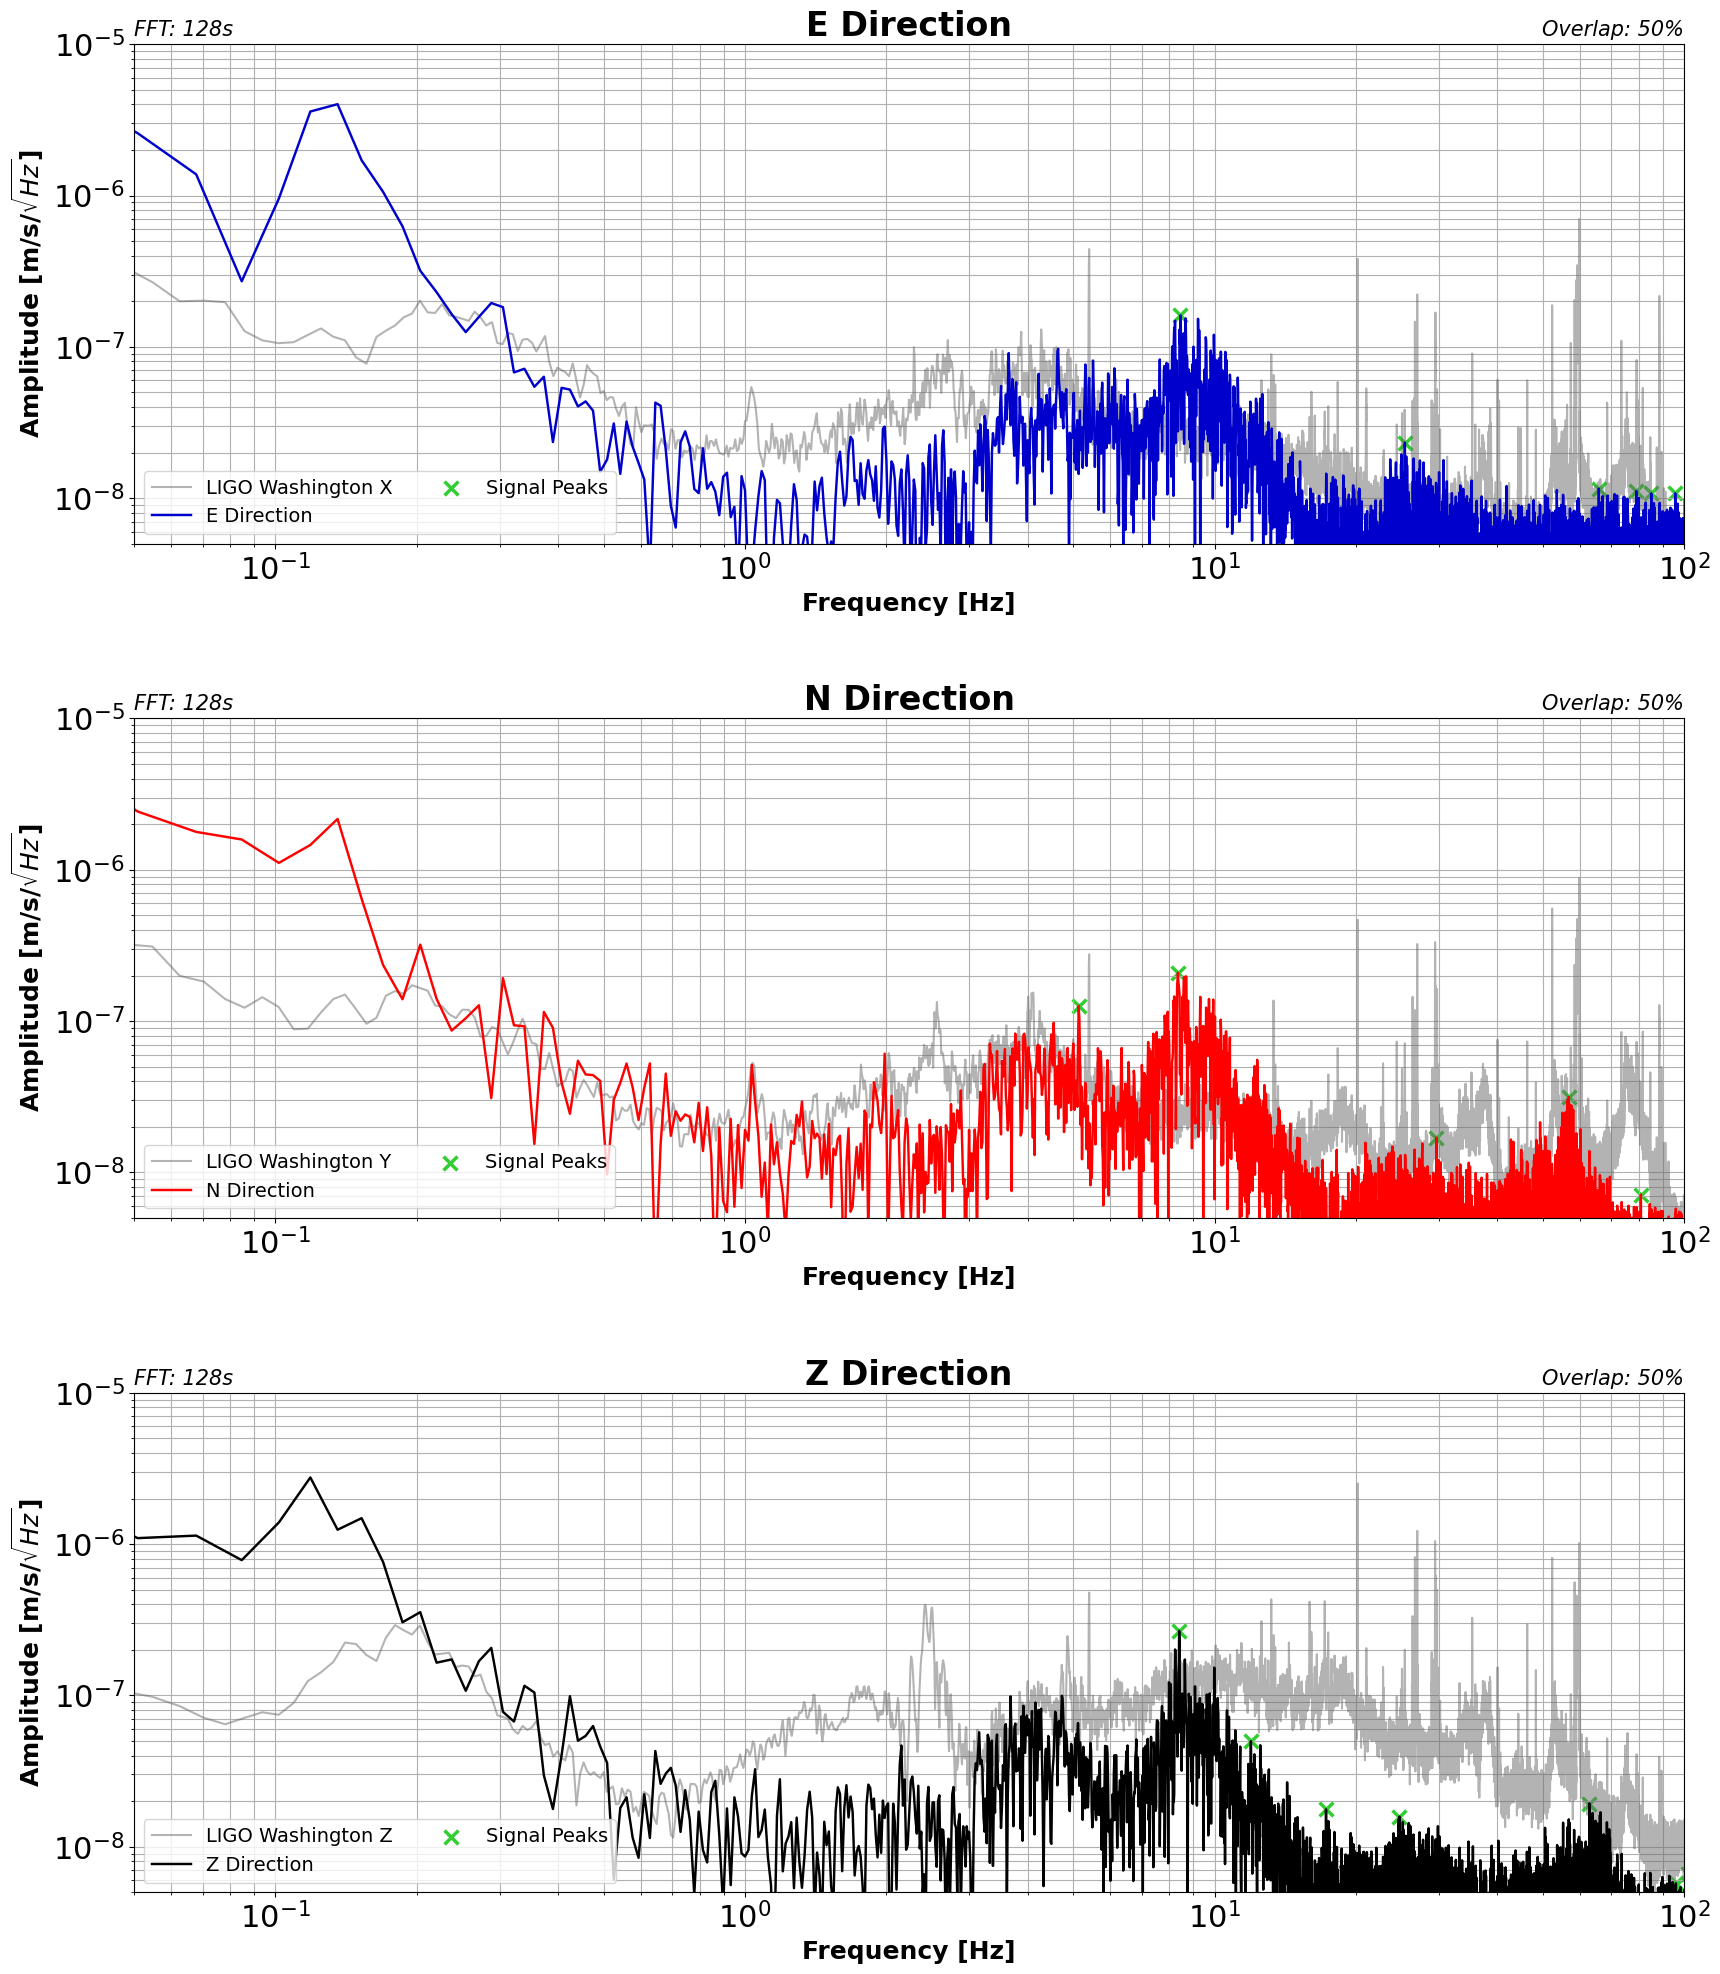

In [8]:
################################################################################################################################
#------------------------------ This gets plotted as a multipanel plot via gridspec and subplot -------------------------------#
################################################################################################################################

fig = plt.figure(figsize = (20,24))
gs = gridspec.GridSpec(3,1, height_ratios = [1,1,1], hspace = 0.35)


######################################################### Channel E ############################################################


axis1 = fig.add_subplot(gs[0,0])
axis1.set_yscale('log')
axis1.set_xscale('log')
axis1.tick_params(labelsize=22)

#------------------------------------------------------ Plots LIGO Data -------------------------------------------------------#

if os.path.exists(control_data_path):
    axis1.plot(hf,hx, color = "dimgrey", label = "LIGO Washington X", alpha = 0.5)
else:
    print("LIGO data not found")

#------------------------------------------------------------------------------------------------------------------------------#

axis1.plot(f_e, ae, color = 'mediumblue', linewidth = 1.75, label = 'E Direction')

axis1.scatter(f_e[peak_e], ae[peak_e], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5, label = 'Signal Peaks')

axis1.set_title('FFT: ' + str(fft_length) + "s", fontsize = 15, loc = "left",style ='italic')
axis1.set_title("Overlap: " + str(overlap) + "%", fontsize = 15, loc = "right",style ='italic')

axis1.set_title("E Direction", fontweight = "bold", fontsize = 24)
axis1.set_xlabel("Frequency [Hz]", fontweight = "bold", fontsize = 18)
axis1.set_ylabel("Amplitude [ms⁻¹/√Hz]", fontweight = "bold", fontsize = 18)
axis1.legend(loc = "lower left", fontsize = 14, ncol = 2)

axis1.set_ylim(y_min,y_max)
axis1.set_xlim(x_min,x_max)
axis1.grid(True, which="both", ls="-")


######################################################### Channel N ############################################################


axis2 = fig.add_subplot(gs[1,0])
axis2.set_yscale('log')
axis2.set_xscale('log')
axis2.tick_params(labelsize=22)

#------------------------------------------------------ Plots LIGO Data -------------------------------------------------------#

if os.path.exists(control_data_path):
    axis2.plot(hf,hy, color = "dimgrey", label = "LIGO Washington Y", alpha = 0.5)

#------------------------------------------------------------------------------------------------------------------------------#

axis2.plot(f_n, an, color = 'red', linewidth = 1.75, label = 'N Direction')

axis2.scatter(f_n[peak_n], an[peak_n], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5, label = 'Signal Peaks')

axis2.set_title('FFT: ' + str(fft_length) + "s", fontsize = 15, loc = "left",style ='italic')
axis2.set_title("Overlap: " + str(overlap) + "%", fontsize = 15, loc = "right",style ='italic')

axis2.set_title("N Direction", fontweight = "bold", fontsize = 24)
axis2.set_xlabel("Frequency [Hz]", fontweight = "bold", fontsize = 18)
axis2.set_ylabel("Amplitude [ms⁻¹/√Hz]", fontweight = "bold", fontsize = 18)
axis2.legend(loc = "lower left", fontsize = 14, ncol = 2)

axis2.set_ylim(y_min,y_max)
axis2.set_xlim(x_min,x_max)
axis2.grid(True, which="both", ls="-")


########################################################## Channel Z ###########################################################


axis3 = fig.add_subplot(gs[2,0])
axis3.set_yscale('log')
axis3.set_xscale('log')
axis3.tick_params(labelsize=22)

#------------------------------------------------------ Plots LIGO Data -------------------------------------------------------#

if os.path.exists(control_data_path):
    axis3.plot(hf,hz, color = "dimgrey", label = "LIGO Washington Z", alpha = 0.5)

#------------------------------------------------------------------------------------------------------------------------------#

axis3.plot(f_z, az, color = 'black', linewidth = 1.75, label = 'Z Direction')

axis3.scatter(f_z[peak_z], az[peak_z], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5, label = 'Signal Peaks')

axis3.set_title('FFT: ' + str(fft_length) + "s", fontsize = 15, loc = "left",style ='italic')
axis3.set_title("Overlap: " + str(overlap) + "%", fontsize = 15, loc = "right",style ='italic')

axis3.set_title("Z Direction", fontweight = 'bold' , fontsize = 24)
axis3.set_xlabel("Frequency [Hz]", fontweight = "bold", fontsize = 18)
axis3.set_ylabel("Amplitude [ms⁻¹/√Hz]", fontweight = "bold", fontsize = 18)
axis3.legend(loc = "lower left", fontsize = 14, ncol = 2)

axis3.set_ylim(y_min,y_max)
axis3.set_xlim(x_min,x_max)
axis3.grid(True, which="both", ls="-")


#plt.savefig('place_img_name_here.format', bbox_inches='tight')

## The following cells are used to plot spectrograms for each direction

### These variables are to set limits for the plot and to compute the spectrogram

In [12]:
#------------------------------------------------------ Colorbar Limits -------------------------------------------------------#
cmin = 10e-10
cmax = 10e-8

#-------------------------------------------------------- Plot limits ---------------------------------------------------------#
ymax = 20 ## In terms of frequency
ymin = 0

#-------------------------------------------------------- fft length ----------------------------------------------------------#
fft_len = 10 ## in terms of seconds

#---------------------------------------------------- Precent FFT Overlap -----------------------------------------------------#
olap = 50 ## 50% fft overlap

# This is where the Spectrograms are ploted
## The default plots are autoscaled, you will have to comment out the intial plotting lines, and uncomment the one with the input variables

'\naxis4 = fig.add_subplot(gs[3,0])\n\naxis4.set_title("Noise Direction", fontweight = \'bold\' , fontsize = 20)\n\nm3 = axis3.pcolormesh(t, f, np.sqrt(Sxxe), shading=\'gouraud\') ################ This will autoscale the plot ####################\n\n#m3 = axis4.pcolormesh(t, f, np.sqrt(Sxx), shading=\'gouraud\', vmin = cmin, vmax = cmax) #### Uncomment this to add inputs ###\n\naxis3.set_title("Electronic Noise", fontweight = \'bold\' , fontsize = 20)\naxis3.set_xlabel(\'Time (s)\', fontweight = \'bold\' , fontsize = 18)\naxis4.set_ylabel(\'Frequency (Hz)\', fontweight = \'bold\' , fontsize = 18)\naxis3.tick_params(labelsize=16)\n\ncbar3 = fig.colorbar(m3, pad = 0.02)\ncbar3.ax.tick_params(labelsize=14)\ncbar3.set_label(label=\'Intensity [m/s/$\\sqrt{Hz}$]\' ,weight=\'bold\', fontsize = 14)\n\n\n#axis4.set_ylim(ymin, ymax) ## Uncomment to add limits\n\n#plt.savefig(\'**place_img_name_here.format**\', bbox_inches=\'tight\')\n'

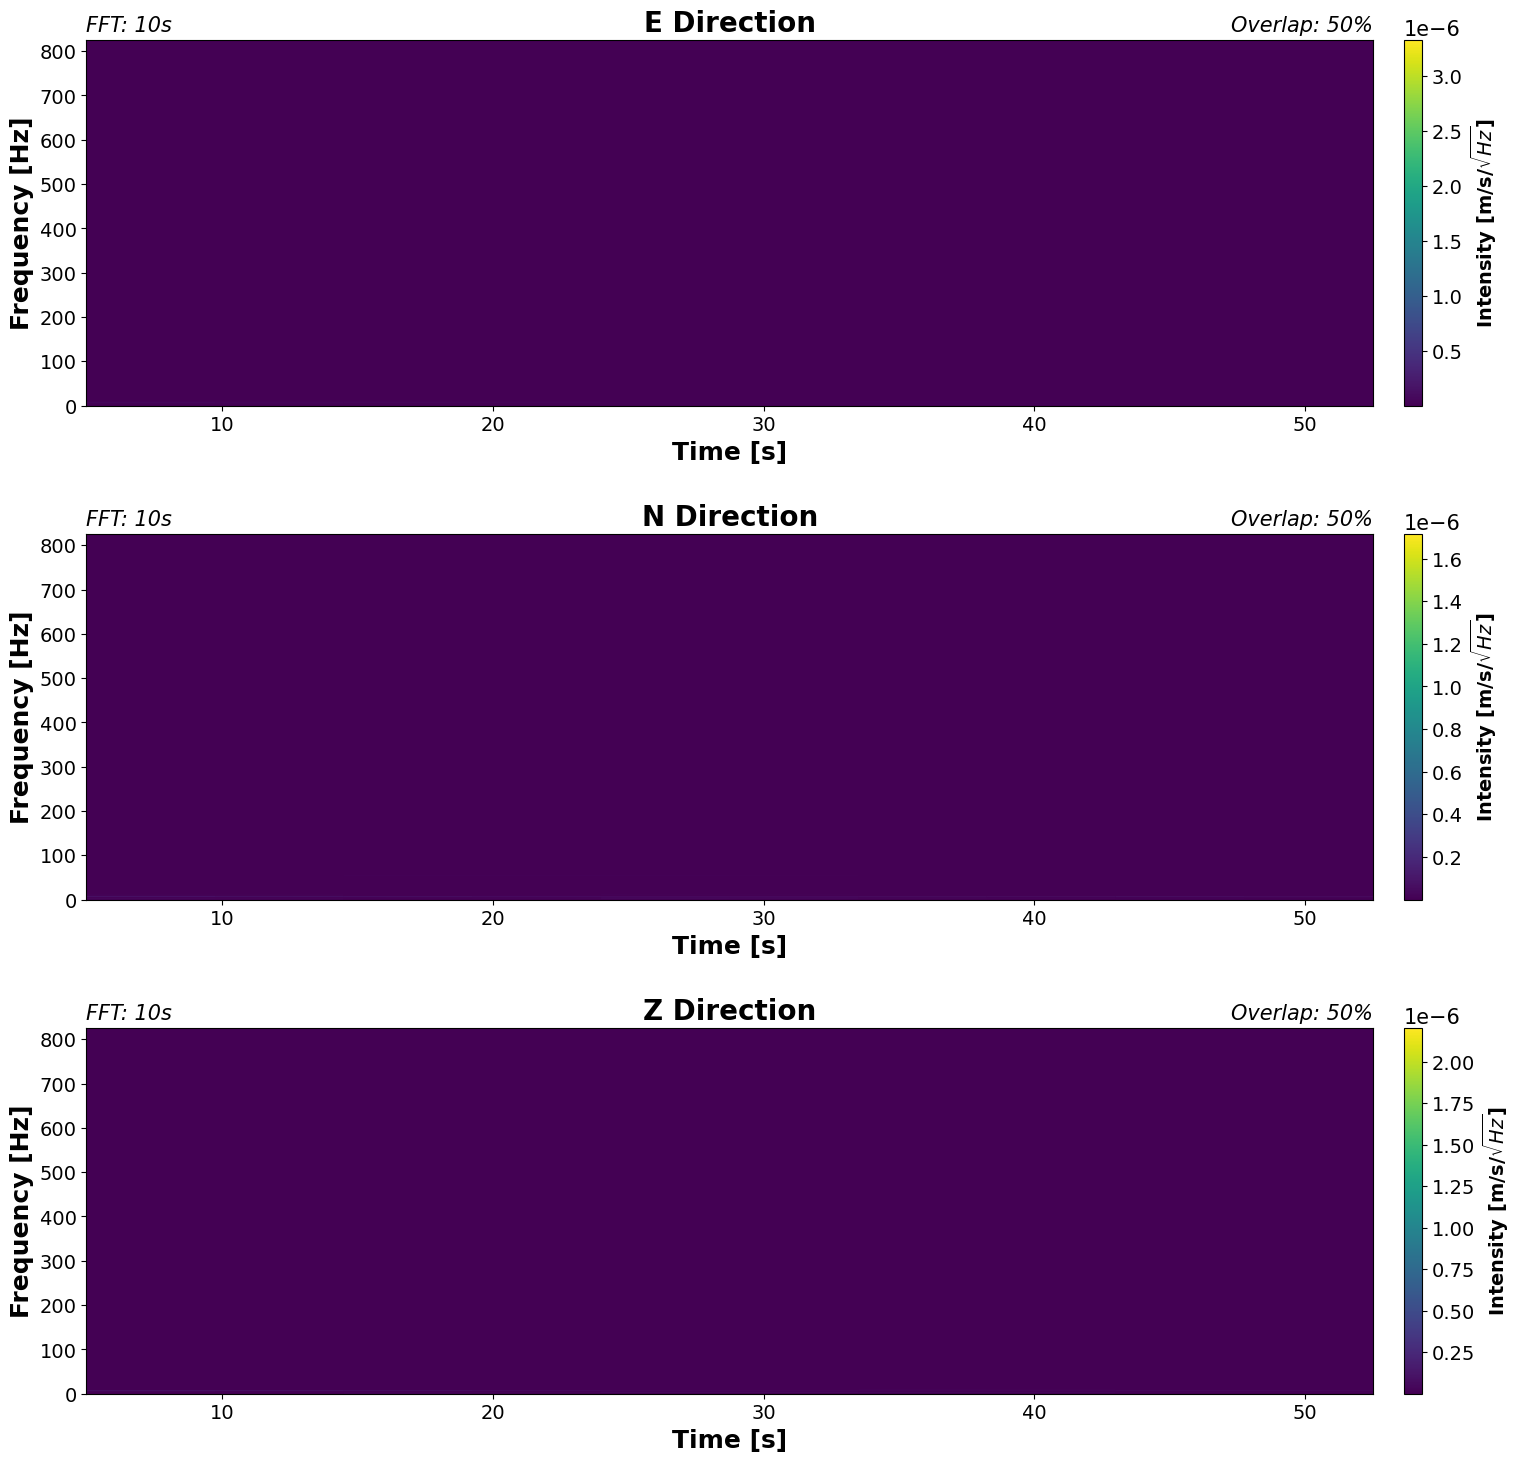

In [15]:
################################################################################################################################
#----------------------------- The spectrograms are calculated with signal.spectrogram from SciPy -----------------------------#
################################################################################################################################
warnings.simplefilter('ignore')

fz, tz, Sxxz = signal.spectrogram(z, sr, window= 'hamming', nperseg=round(sr *fft_len), noverlap= round(sr *(olap *0.01)) )
fn, tn, Sxxn = signal.spectrogram(n, sr, window= 'hamming', nperseg=round(sr *fft_len), noverlap= round(sr *(olap *0.01)) )
fe, te, Sxxe = signal.spectrogram(e, sr, window= 'hamming', nperseg=round(sr *fft_len), noverlap= round(sr *(olap *0.01)) )
#f, t, Sxx = signal.spectrogram(noi, sr, window= 'hamming', nperseg=round(sr *fft_len), noverlap= round(sr *(olap *0.01)) )


fig = plt.figure(figsize = (20,24))

gs = gridspec.GridSpec(4,1, height_ratios = [1,1,1,1], hspace = 0.35)


####################################################### Channel E ##############################################################


axis3 = fig.add_subplot(gs[0,0])

m2 = axis3.pcolormesh(te, fe, np.sqrt(Sxxe), shading='gouraud') #---------------- This will autoscale the plot ----------------#
                                                                #- If you want to change the limits, uncomment the line below -#
                                                                #----------- Be sure to comment out the line above ------------#

#m2 = axis3.pcolormesh(te, fe, np.sqrt(Sxxe), shading='gouraud', vmin = cmin, vmax = cmax) ### Uncomment this to add inputs ###

axis3.set_title('FFT: ' + str(fft_len) + "s", fontsize = 15, loc = "left",style ='italic')
axis3.set_title("Overlap: " + str(olap) + "%", fontsize = 15, loc = "right",style ='italic')

axis3.set_title("E Direction", fontweight = 'bold' , fontsize = 20)
axis3.set_xlabel('Time [s]', fontweight = 'bold' , fontsize = 18)
axis3.set_ylabel('Frequency [Hz]', fontweight = 'bold' , fontsize = 18)
axis3.tick_params(labelsize=17)

cbar2 = fig.colorbar(m2, pad = 0.02)
cbar2.ax.tick_params(labelsize = 14)
cbar2.set_label(label='Intensity [ms⁻¹/√Hz]' ,weight='bold', fontsize = 14)
cbar2.ax.yaxis.offsetText.set_fontsize(15)
cbar2.ax.yaxis.set_offset_position('left')

#axis3.set_ylim(ymin, ymax) ## Uncomment to add limits


####################################################### Channel N ##############################################################


axis2 = fig.add_subplot(gs[1,0])

m1 = axis2.pcolormesh(tn, fn, np.sqrt(Sxxn), shading='gouraud') #--------------- This will autoscale the plot -----------------#

#m1 = axis2.pcolormesh(tn, fn, np.sqrt(Sxxn), shading='gouraud', vmin = cmin, vmax = cmax) ### Uncomment this to add inputs ###

axis2.set_title('FFT: ' + str(fft_len) + "s", fontsize = 15, loc = "left",style ='italic')
axis2.set_title("Overlap: " + str(olap) + "%", fontsize = 15, loc = "right",style ='italic')

axis2.set_title("N Direction", fontweight = 'bold' , fontsize = 20)
axis2.set_xlabel('Time [s]', fontweight = 'bold' , fontsize = 18)
axis2.set_ylabel('Frequency [Hz]', fontweight = 'bold' , fontsize = 18)
axis2.tick_params(labelsize=17)


cbar1 = fig.colorbar(m1, pad = 0.02)
cbar1.ax.tick_params(labelsize = 14)
cbar1.set_label(label='Intensity [ms⁻¹/√Hz]' ,weight='bold', fontsize = 14)
cbar1.ax.yaxis.offsetText.set_fontsize(15)
cbar1.ax.yaxis.set_offset_position('left')

#axis2.set_ylim(ymin, ymax) ## Uncomment to add limits


####################################################### Channel Z ##############################################################

axis1 = fig.add_subplot(gs[2,0])

m0 = axis1.pcolormesh(tz, fz, np.sqrt(Sxxz), shading='gouraud') #--------------- This will autoscale the plot -----------------#
     
#m0 = axis1.pcolormesh(tz, fz, np.sqrt(Sxxz), shading='gouraud', vmin = cmin, vmax = cmax) ### Uncomment this to add inputs ###

axis1.set_title('FFT: ' + str(fft_len) + "s", fontsize = 15, loc = "left",style ='italic')
axis1.set_title("Overlap: " + str(olap) + "%", fontsize = 15, loc = "right",style ='italic')

axis1.set_title("Z Direction", fontweight = 'bold' , fontsize = 20)
axis1.set_xlabel('Time [s]', fontweight = 'bold' , fontsize = 18)
axis1.set_ylabel('Frequency [Hz]', fontweight = 'bold' , fontsize = 18)
axis1.tick_params(labelsize=17)

cbar0 = fig.colorbar(m0, pad = 0.02)
cbar0.ax.tick_params(labelsize = 14)
cbar0.set_label(label='Intensity [ms⁻¹/√Hz]' ,weight='bold', fontsize = 14)
cbar0.ax.yaxis.offsetText.set_fontsize(15)
cbar0.ax.yaxis.set_offset_position('left')

#axis1.set_ylim(ymin,ymax) ## Uncomment to add limits


###################################################### Noise Channel ###########################################################
'''
axis4 = fig.add_subplot(gs[3,0])

axis4.set_title("Noise Direction", fontweight = 'bold' , fontsize = 20)

m3 = axis3.pcolormesh(t, f, np.sqrt(Sxxe), shading='gouraud') ################ This will autoscale the plot ####################

#m3 = axis4.pcolormesh(t, f, np.sqrt(Sxx), shading='gouraud', vmin = cmin, vmax = cmax) #### Uncomment this to add inputs ###

axis3.set_title("Electronic Noise", fontweight = 'bold' , fontsize = 20)
axis3.set_xlabel('Time (s)', fontweight = 'bold' , fontsize = 18)
axis4.set_ylabel('Frequency (Hz)', fontweight = 'bold' , fontsize = 18)
axis3.tick_params(labelsize=16)

cbar3 = fig.colorbar(m3, pad = 0.02)
cbar3.ax.tick_params(labelsize=14)
cbar3.set_label(label='Intensity [ms⁻¹/√Hz]' ,weight='bold', fontsize = 14)


#axis4.set_ylim(ymin, ymax) ## Uncomment to add limits
'''


#plt.savefig('place_img_name_here.format', bbox_inches='tight')


################################################################################################################################
################################### These may take a while to plot, since they are so dense ####################################